In [ ]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
GIT_USERNAME = "nbeili" # replace with yours
GIT_TOKEN = ""           # definitely replace with yours
GIT_REPOSITORY = "Metadata-extraction-from-German-scientific-papers"

In [ ]:
GIT_PATH = "https://"+GIT_TOKEN+"@github.com/"+GIT_USERNAME+"/"+GIT_REPOSITORY+".git"

In [ ]:
!git clone "{GIT_PATH}"

Cloning into 'Metadata-extraction-from-German-scientific-papers'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 769 (delta 12), reused 8 (delta 0), pack-reused 737
Receiving objects: 100% (769/769), 37.80 MiB | 28.13 MiB/s, done.
Resolving deltas: 100% (334/334), done.


In [ ]:
%cd Metadata-extraction-from-German-scientific-papers

/content/Metadata-extraction-from-German-scientific-papers


In [ ]:
!git pull

In [ ]:
# install detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

In [ ]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger

import detectron2
from detectron2.utils.logger import setup_logger
#setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog


In [ ]:

# Register a dataset in COCO’s json annotation format for instance detection, instance segmentation and keypoint detection. 
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/Metadata-extraction-from-German-scientific-papers/new_annotations/train/train_coco.json", "/content/Metadata-extraction-from-German-scientific-papers/new_annotations/train")
register_coco_instances("my_dataset_val", {}, "/content/Metadata-extraction-from-German-scientific-papers/new_annotations/val/val_coco.json", "/content/Metadata-extraction-from-German-scientific-papers/new_annotations/val")
#register_coco_instances("my_dataset_test", {}, "/content/Metadata-extraction-from-German-scientific-papers/new_annotations/test/test_coco.json", "/content/Metadata-extraction-from-German-scientific-papers/new_annotations/test")


In [ ]:
from detectron2.data import DatasetCatalog, MetadataCatalog

train_metadata = MetadataCatalog.get("my_dataset_train") #return the Metadata instance associated with this name
train_dataset = DatasetCatalog.get("my_dataset_train") # Call the registered function and return dataset annotations

In [ ]:
# take a look at the data to see if the images are loaded correctly
from google.colab.patches import cv2_imshow
for d in random.sample(train_dataset, 3):
    print(d["file_name"])
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.2)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [ ]:
import os
import datetime
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

# create the output dir for the trained model
output_dir = os.path.join("/content/drive/My Drive/Colab Notebooks", datetime.datetime.now().strftime('%Y%m%dT%H%M'))
os.makedirs(output_dir, exist_ok=True)
# change the config in the .yaml document
cfg = cfg = get_cfg() #load default config
cfg.merge_from_file("/content/drive/My Drive/FinalDataset/DLA_mask_rcnn_X_101_32x8d_FPN_3x.yaml")
cfg.OUTPUT_DIR = output_dir #change the output path
cfg.DATASETS.TRAIN = ("my_dataset_train",) #specify the trainning dataset
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "/content/drive/My Drive/FinalDataset/model_final_trimmed.pth"  # load intial weights from the pre-trained model in publaynet
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.PANOPTIC_FPN.COMBINE.INSTANCES_CONFIDENCE_THRESH = 0.5
cfg.SOLVER.IMS_PER_BATCH = 2
# cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 5000    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
# cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 9
cfg.MODEL.BACKBONE.FREEZE_AT= 4 #freeze the stem and 3 backbone layers
#serialize the training config
cfg_str = cfg.dump()
with open(os.path.join(cfg.OUTPUT_DIR, "train_config.yaml"), "w") as f:  #write the new config in the 'train_config.yaml'
  f.write(cfg_str)
f.close()

# using hpanwar08's trainer specified in the cell above
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()



Config '/content/drive/My Drive/FinalDataset/DLA_mask_rcnn_X_101_32x8d_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


[07/12 23:39:04 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Unable to load 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (6, 1024) in the checkpoint but (10, 1024) in the model!
Unable to load 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (6,) in the checkpoint but (10,) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (20, 1024) in the checkpoint but (36, 1024) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (20,) in the checkpoint but (36,) in the model!
Unable to load 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (5, 256, 1, 1) in the checkpoint but (9, 256, 1, 1) in the model!
Unable to load 'roi_heads.mask_head.predictor.bias' to the model due to incompatible shapes: (5,) in the checkpoint but (9,) in the model!


[07/12 23:39:18 d2.engine.train_loop]: Starting training from iteration 0
[07/12 23:39:27 d2.utils.events]:  eta: 0:37:23  iter: 19  total_loss: 3.527  loss_cls: 2.250  loss_box_reg: 0.139  loss_mask: 0.691  loss_rpn_cls: 0.181  loss_rpn_loc: 0.192  time: 0.4586  data_time: 0.0141  lr: 0.000018  max_mem: 2237M
[07/12 23:39:36 d2.utils.events]:  eta: 0:37:55  iter: 39  total_loss: 3.101  loss_cls: 1.903  loss_box_reg: 0.128  loss_mask: 0.682  loss_rpn_cls: 0.124  loss_rpn_loc: 0.138  time: 0.4596  data_time: 0.0046  lr: 0.000036  max_mem: 2237M
[07/12 23:39:45 d2.utils.events]:  eta: 0:37:40  iter: 59  total_loss: 2.320  loss_cls: 1.211  loss_box_reg: 0.151  loss_mask: 0.664  loss_rpn_cls: 0.090  loss_rpn_loc: 0.154  time: 0.4565  data_time: 0.0046  lr: 0.000054  max_mem: 2237M
[07/12 23:39:54 d2.utils.events]:  eta: 0:37:25  iter: 79  total_loss: 1.754  loss_cls: 0.644  loss_box_reg: 0.162  loss_mask: 0.633  loss_rpn_cls: 0.089  loss_rpn_loc: 0.158  time: 0.4519  data_time: 0.0052  lr:

In [ ]:
print(output_dir)

/content/drive/My Drive/Colab Notebooks/20200712T2338


In [ ]:
# Look at training curves in tensorboard:

%load_ext tensorboard
%tensorboard --logdir output

In [ ]:
#import os
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("my_dataset_val", )
predictor = DefaultPredictor(cfg)

In [ ]:
val_metadata = MetadataCatalog.get("my_dataset_val") #return the Metadata instance associated with this name
val_dataset = DatasetCatalog.get("my_dataset_val") # Call the registered function and return dataset annotations

WARNING [07/13 00:22:32 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/13 00:22:32 d2.data.datasets.coco]: Loaded 17 images in COCO format from /content/Metadata-extraction-from-German-scientific-papers/new_annotations/val/val_coco.json


WARNING [07/13 00:22:51 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/13 00:22:51 d2.data.datasets.coco]: Loaded 17 images in COCO format from /content/Metadata-extraction-from-German-scientific-papers/new_annotations/val/val_coco.json
/content/Metadata-extraction-from-German-scientific-papers/new_annotations/val/10831.jpeg


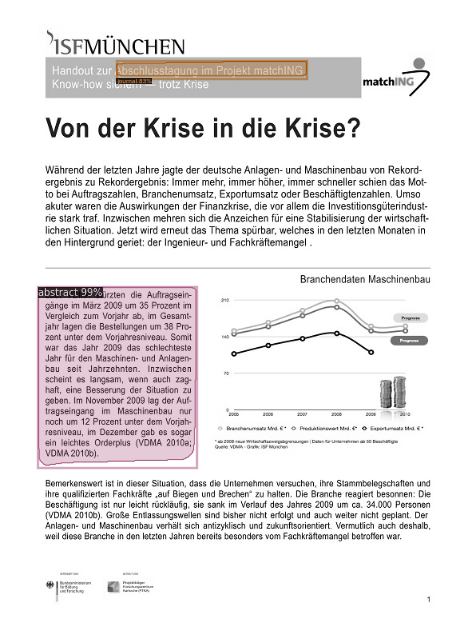

/content/Metadata-extraction-from-German-scientific-papers/new_annotations/val/10939.jpeg


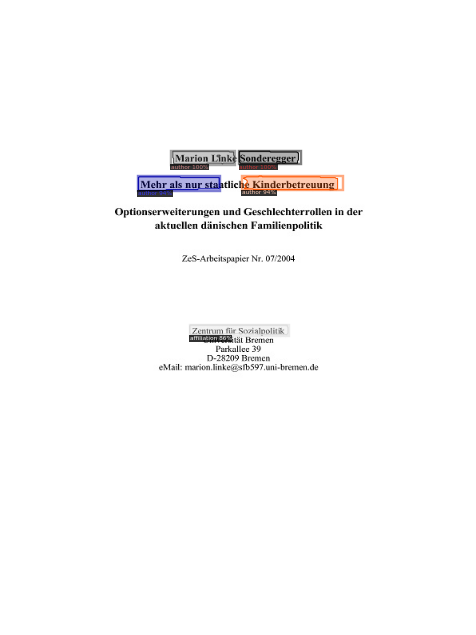

/content/Metadata-extraction-from-German-scientific-papers/new_annotations/val/11423.jpeg


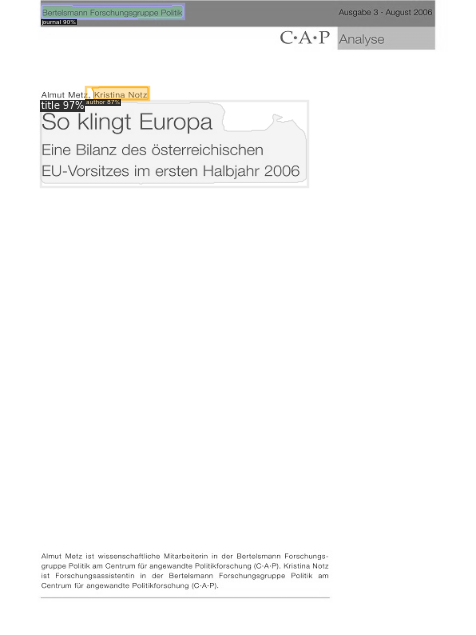

/content/Metadata-extraction-from-German-scientific-papers/new_annotations/val/11593.jpeg


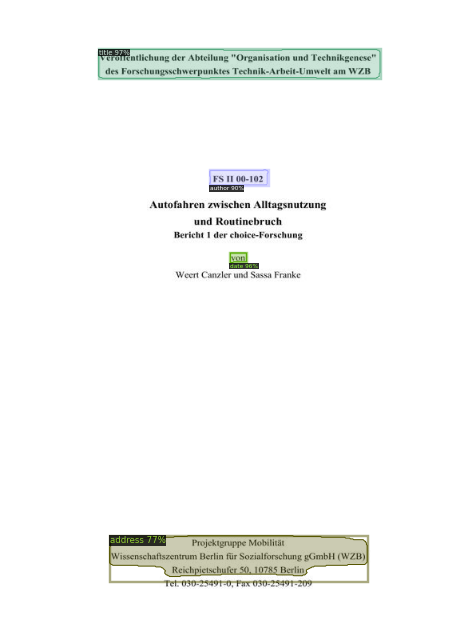

/content/Metadata-extraction-from-German-scientific-papers/new_annotations/val/11916.jpeg


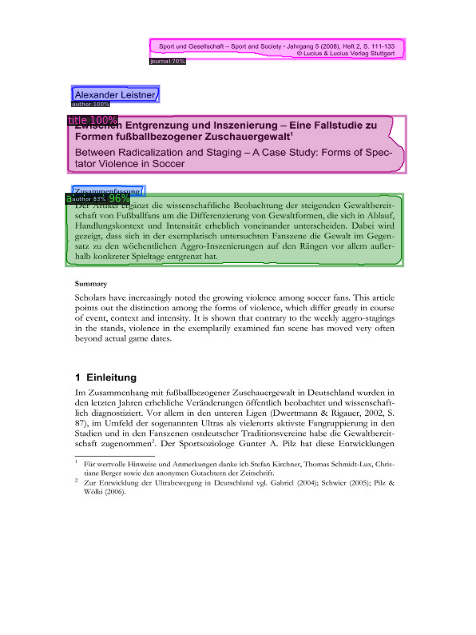

/content/Metadata-extraction-from-German-scientific-papers/new_annotations/val/1528.jpeg


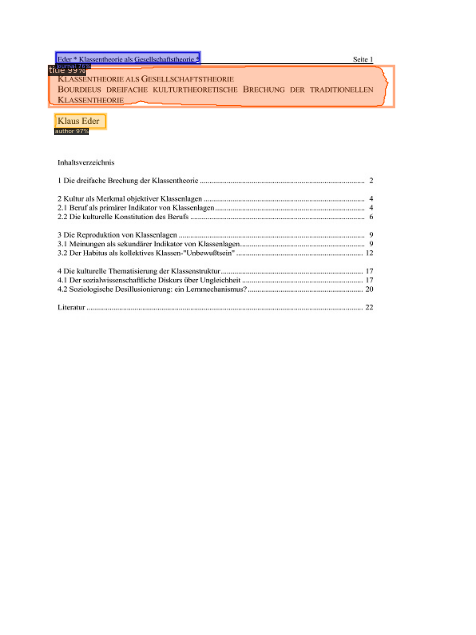

/content/Metadata-extraction-from-German-scientific-papers/new_annotations/val/17253.jpeg


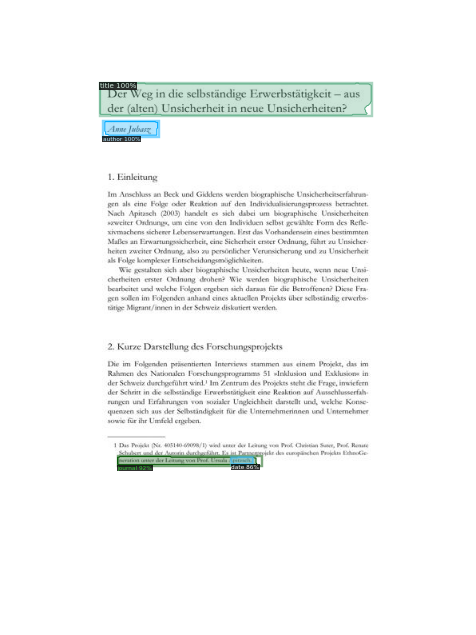

/content/Metadata-extraction-from-German-scientific-papers/new_annotations/val/17421.jpeg


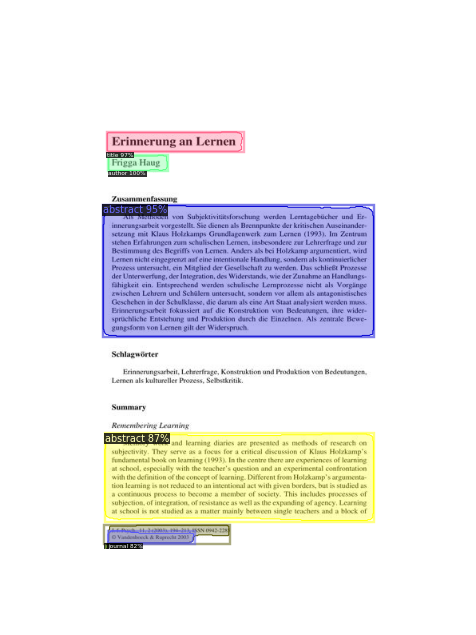

/content/Metadata-extraction-from-German-scientific-papers/new_annotations/val/18436.jpeg


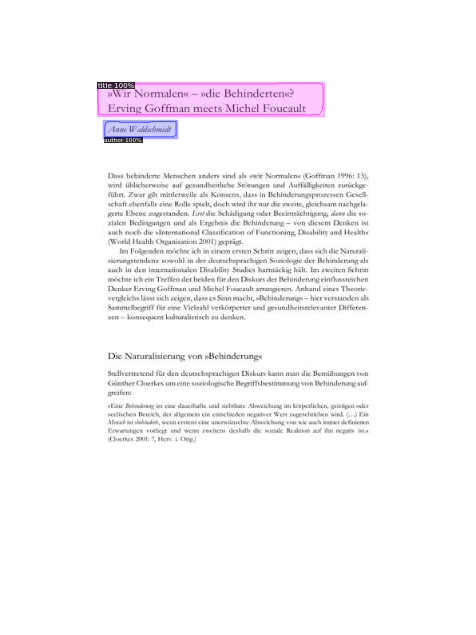

/content/Metadata-extraction-from-German-scientific-papers/new_annotations/val/23371.jpeg


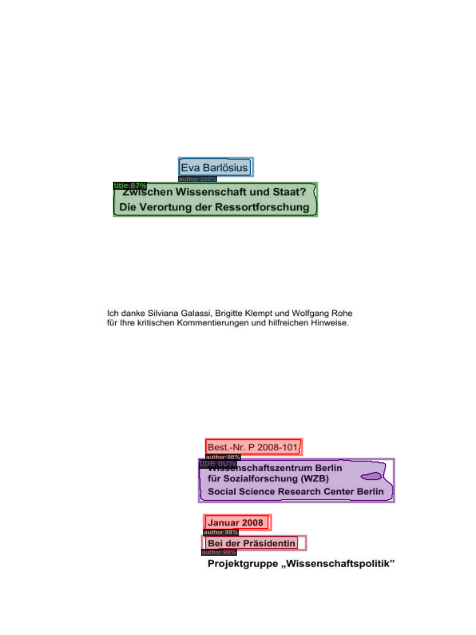

/content/Metadata-extraction-from-German-scientific-papers/new_annotations/val/3169.jpeg


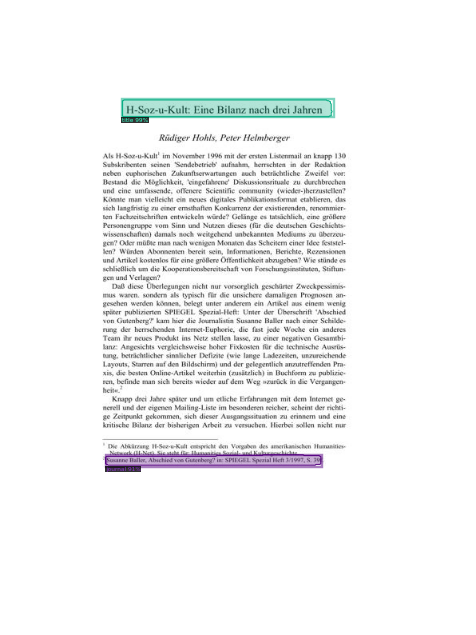

/content/Metadata-extraction-from-German-scientific-papers/new_annotations/val/35056.jpeg


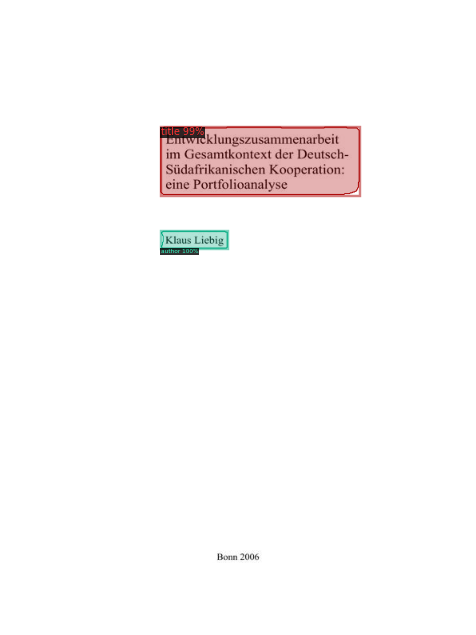

/content/Metadata-extraction-from-German-scientific-papers/new_annotations/val/36025.jpeg


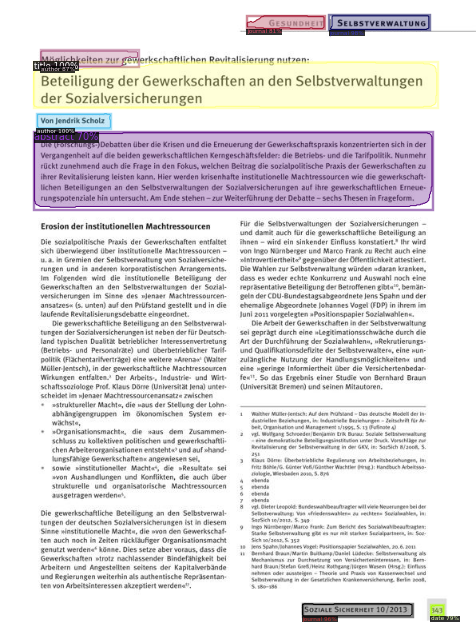

/content/Metadata-extraction-from-German-scientific-papers/new_annotations/val/41733.jpeg


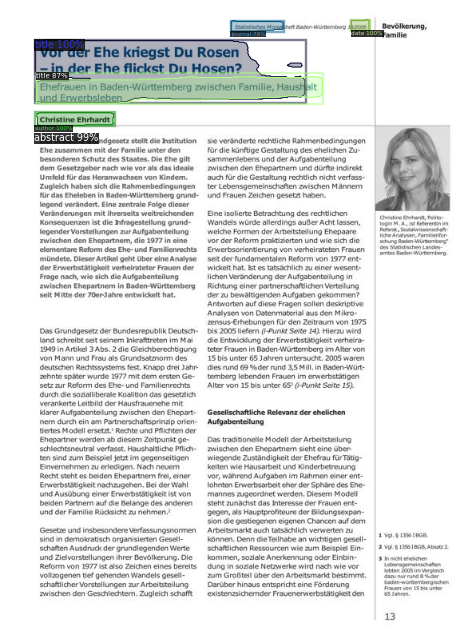

/content/Metadata-extraction-from-German-scientific-papers/new_annotations/val/4379.jpeg


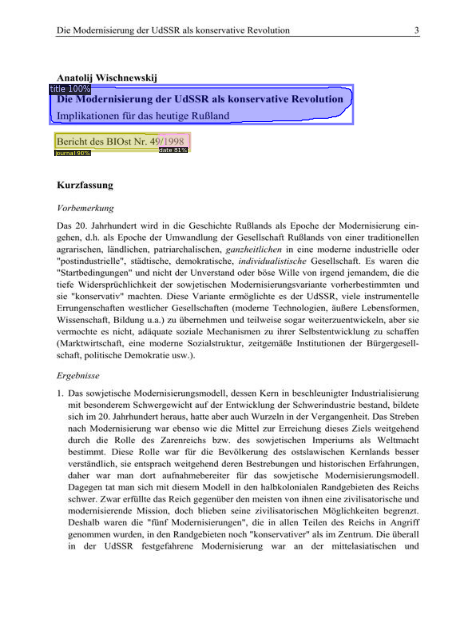

/content/Metadata-extraction-from-German-scientific-papers/new_annotations/val/48208.jpeg


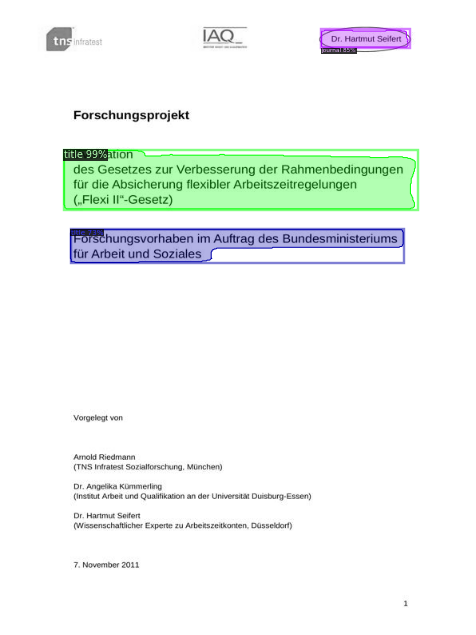

/content/Metadata-extraction-from-German-scientific-papers/new_annotations/val/48550.jpeg


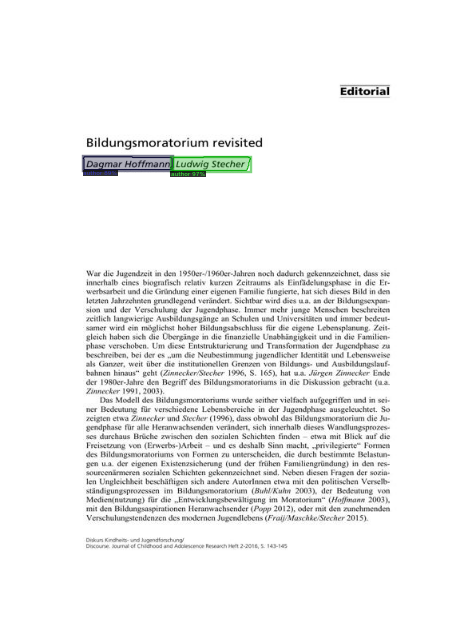

In [ ]:
from detectron2.utils.visualizer import ColorMode
#dataset_dicts_val = DatasetCatalog.get("my_dataset_val")
for d in val_dataset:
    print(d["file_name"])  
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("my_dataset_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

WARNING [07/13 00:23:52 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/13 00:23:52 d2.data.datasets.coco]: Loaded 17 images in COCO format from /content/Metadata-extraction-from-German-scientific-papers/new_annotations/val/val_coco.json
[07/13 00:23:52 d2.data.build]: Distribution of instances among all 9 categories:
|  category  | #instances   |  category  | #instances   |  category   | #instances   |
|:----------:|:-------------|:----------:|:-------------|:-----------:|:-------------|
|  abstract  | 6            |  address   | 4            | affiliation | 8            |
|   author   | 22           |    date    | 12           |     doi     | 1            |
|   email    | 1            |  journal   | 7            |    title    | 19           |
|            |              |            |              |             |              |
|   total    | 80           |            |              |             |              |
[

OrderedDict([('bbox',
              {'AP': 17.53513286900619,
               'AP-abstract': 53.85502121640736,
               'AP-address': 7.7227722772277225,
               'AP-affiliation': 2.5742574257425743,
               'AP-author': 24.620967507015497,
               'AP-date': 7.376237623762376,
               'AP-doi': 0.0,
               'AP-email': 0.0,
               'AP-journal': 7.7227722772277225,
               'AP-title': 53.94416749367246,
               'AP50': 25.652007222722645,
               'AP75': 20.48016503354429,
               'APl': 50.15509696574053,
               'APm': 17.170258836933055,
               'APs': 4.74009900990099}),
             ('segm',
              {'AP': 16.88605210181401,
               'AP-abstract': 55.10325318246111,
               'AP-address': 7.7227722772277225,
               'AP-affiliation': 2.8960396039603964,
               'AP-author': 25.446323244616064,
               'AP-date': 7.376237623762376,
               'AP-do

In [ ]:
im = cv2.imread("/content/drive/My Drive/ML/all_May_2020/val1/images/49817.jpeg")
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
               metadata=papers_metadata, 
               scale=0.8, 
               instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
               )
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
# this function takes an image as input and return the predected classes and bounding_box in json file
import json
import re
def predic_json(image_path):
  d = {}
  d['image_name']=image_path.split('/')[-1]
  im = cv2.imread(image_path)
  outputs = predictor(im)
  d['pred_classes']=re.findall('\[(.*?)\]',str(outputs["instances"].pred_classes))
  d['pred_boxes']= str(outputs["instances"].pred_boxes)
  d['pred_boxes'] = d['pred_boxes'][d['pred_boxes'].find( '[[' ):d['pred_boxes'].find( ']]' )+1].strip('\n\t')
  #r = json.dumps(d)
  with open('/content/drive/My Drive/ML/data.json', 'w') as fp:
     json.dump(d, fp, sort_keys=True, indent=4)
  

In [ ]:
predic_json("/content/drive/My Drive/ML/all_May_2020/val1/images/49817.jpeg")

In [ ]:
import os
#validation works on trained config. So model needs to be trained first.
cfg = get_cfg()
cfg.merge_from_file("/content/drive/My Drive/Colab Notebooks/20200712T2338/train_config.yaml")
#cfg.OUTPUT_DIR = "/content/drive/My Drive/FinalDataset"

#cfg.DATASETS.TRAIN = ("my_dataset_train",)


cfg.MODEL.WEIGHTS = os.path.join("/content/drive/My Drive/Colab Notebooks/20200712T2338", "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("my_dataset_val", )
predictor = DefaultPredictor(cfg)

In [ ]:
cfg.DATASETS.TEST[0]

'my_dataset_val'

In [ ]:
val_metadata = MetadataCatalog.get("my_dataset_val2")

/content/Metadata-extraction-from-German-scientific-papers/new_annotations/val/10939.jpeg


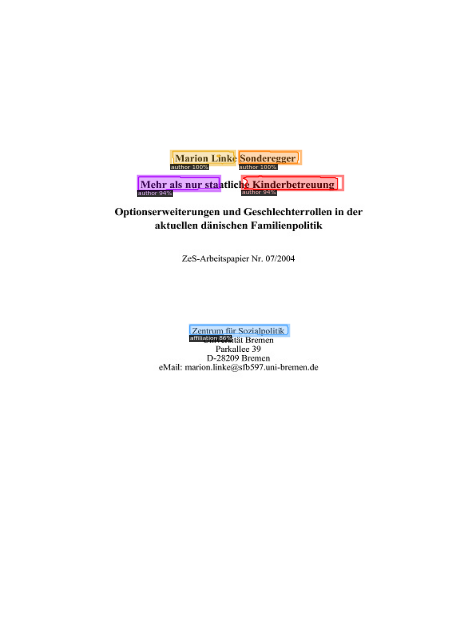

/content/Metadata-extraction-from-German-scientific-papers/new_annotations/val/11593.jpeg


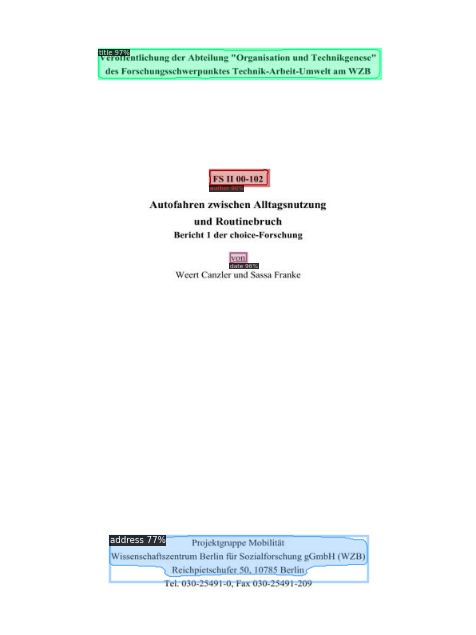

/content/Metadata-extraction-from-German-scientific-papers/new_annotations/val/3169.jpeg


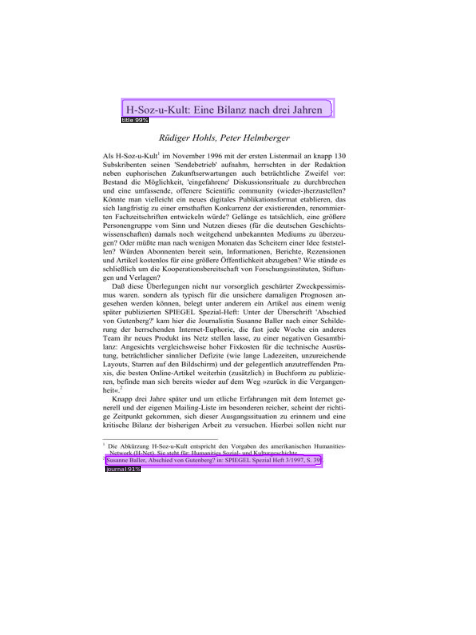

In [ ]:
from detectron2.utils.visualizer import ColorMode
for d in random.sample(val_dataset, 3):    
    print(d["file_name"])
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=MetadataCatalog.get(cfg.DATASETS.TEST[0]), 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

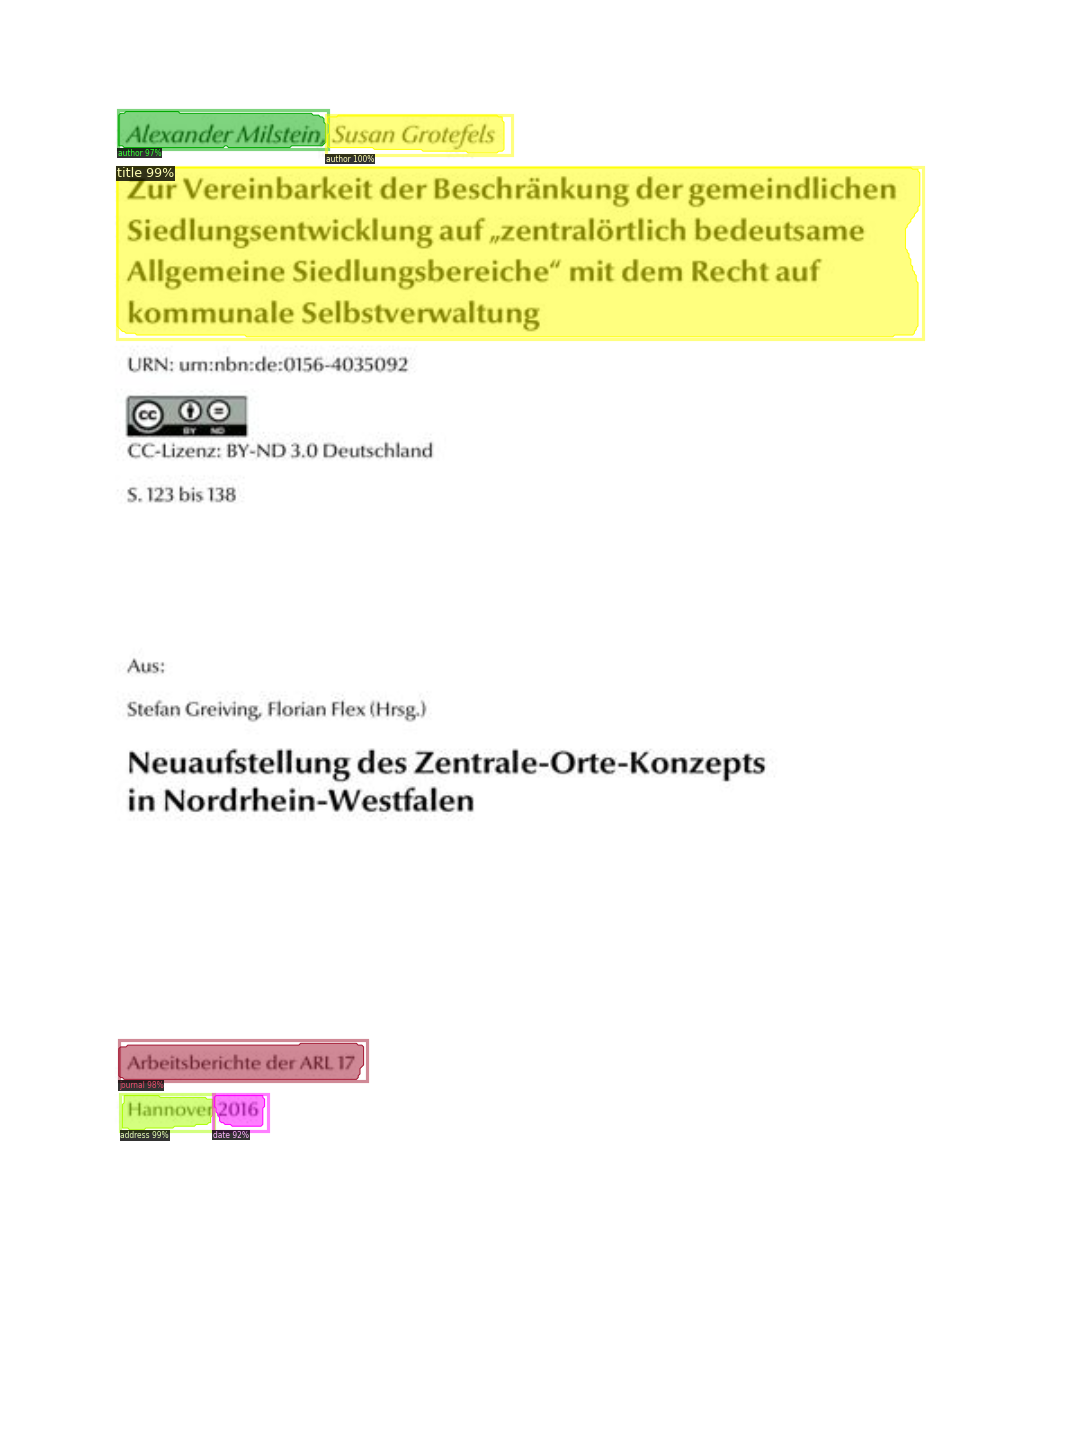

In [ ]:
#Predict for an input
im = cv2.imread("/content/drive/My Drive/FinalDataset/predict/49817.jpeg")
outputs = predictor(im)
#mydic = dict()
#mydic['num-instances'] = outputs.get('instances').__len__()
#mydic['image-size'] = outputs.get('instances').image_size
#mydic['class']=outputs.get('instances').get("pred_classes").tolist()
#mydic['mask-coordinates']=outputs.get('instances').get("pred_boxes").get_centers().tolist()
#mydic['accuracy-score']=outputs.get('instances').get("scores").tolist()
#json.dump(mydic, open("/content/drive/My Drive/FinalDataset/predict/predict.json", 'w'))
v = Visualizer(im[:,:,::-1],metadata=val_metadata, scale=1.8)
#v = Visualizer(im[:, :, ::-1], metadata=val_metadata, scale=0.8, 
#                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
#    )
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
register_coco_instances("my_dataset_test", {}, "/content/Metadata-extraction-from-German-scientific-papers/new_annotations/test/test_coco.json", "/content/Metadata-extraction-from-German-scientific-papers/new_annotations/test")

In [ ]:
test_metadata = MetadataCatalog.get("my_dataset_test")

In [ ]:
dataset_dicts_test = DatasetCatalog.get("my_dataset_test")


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



/content/Metadata-extraction-from-German-scientific-papers/new_annotations/test/11190.jpeg


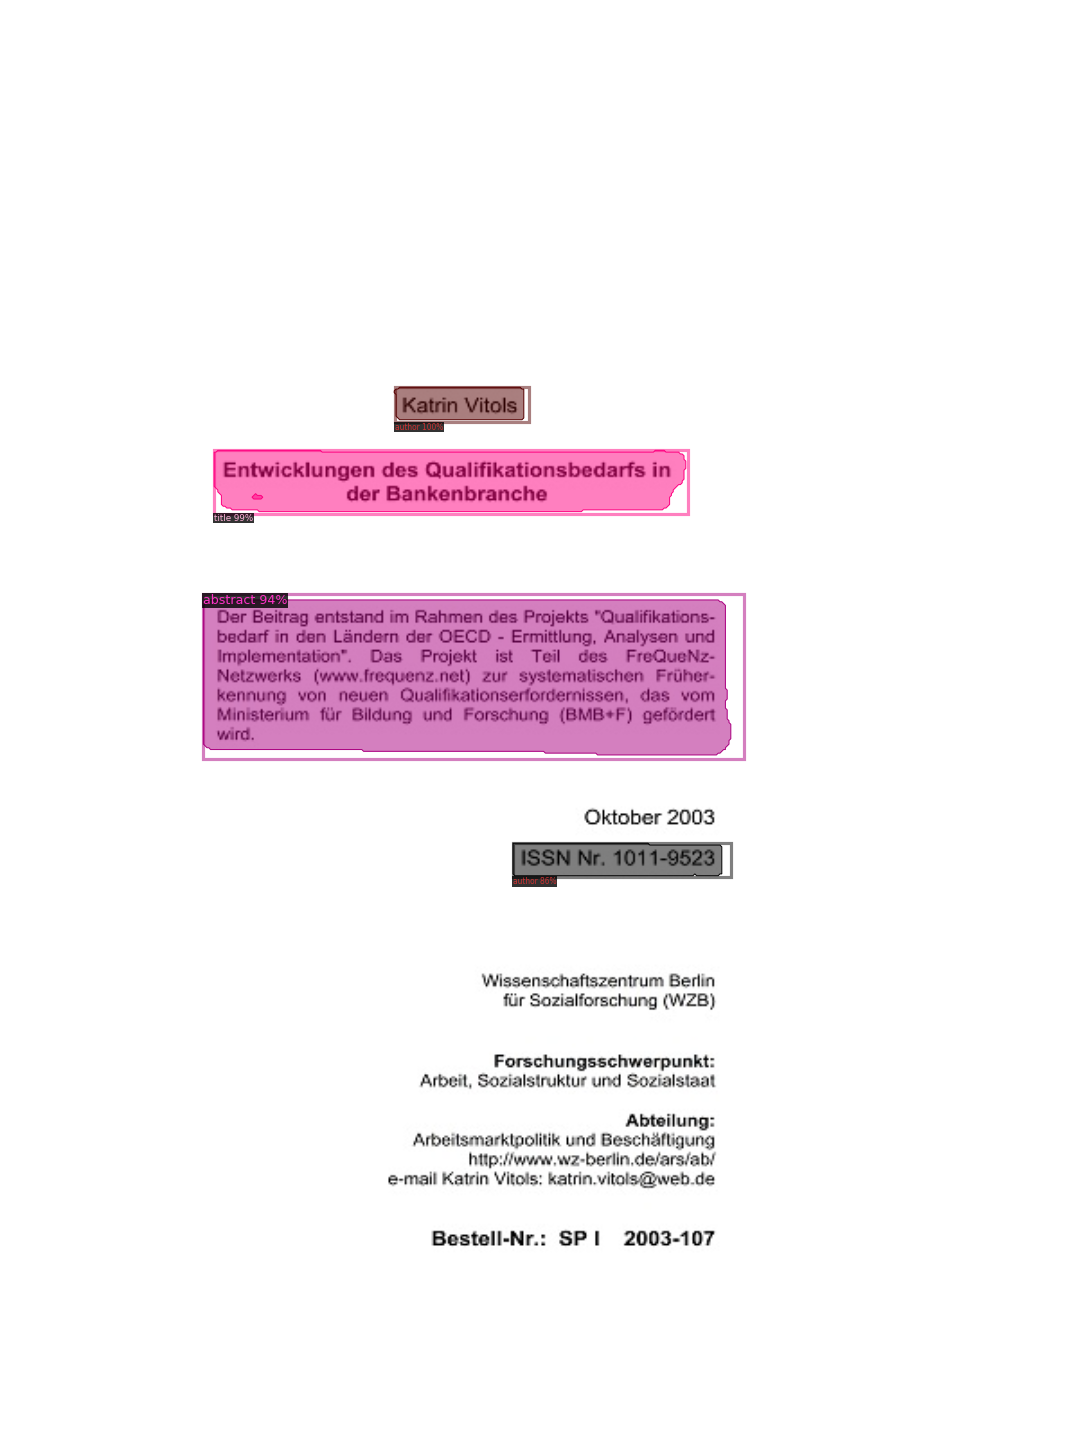

/content/Metadata-extraction-from-German-scientific-papers/new_annotations/test/22006.jpeg


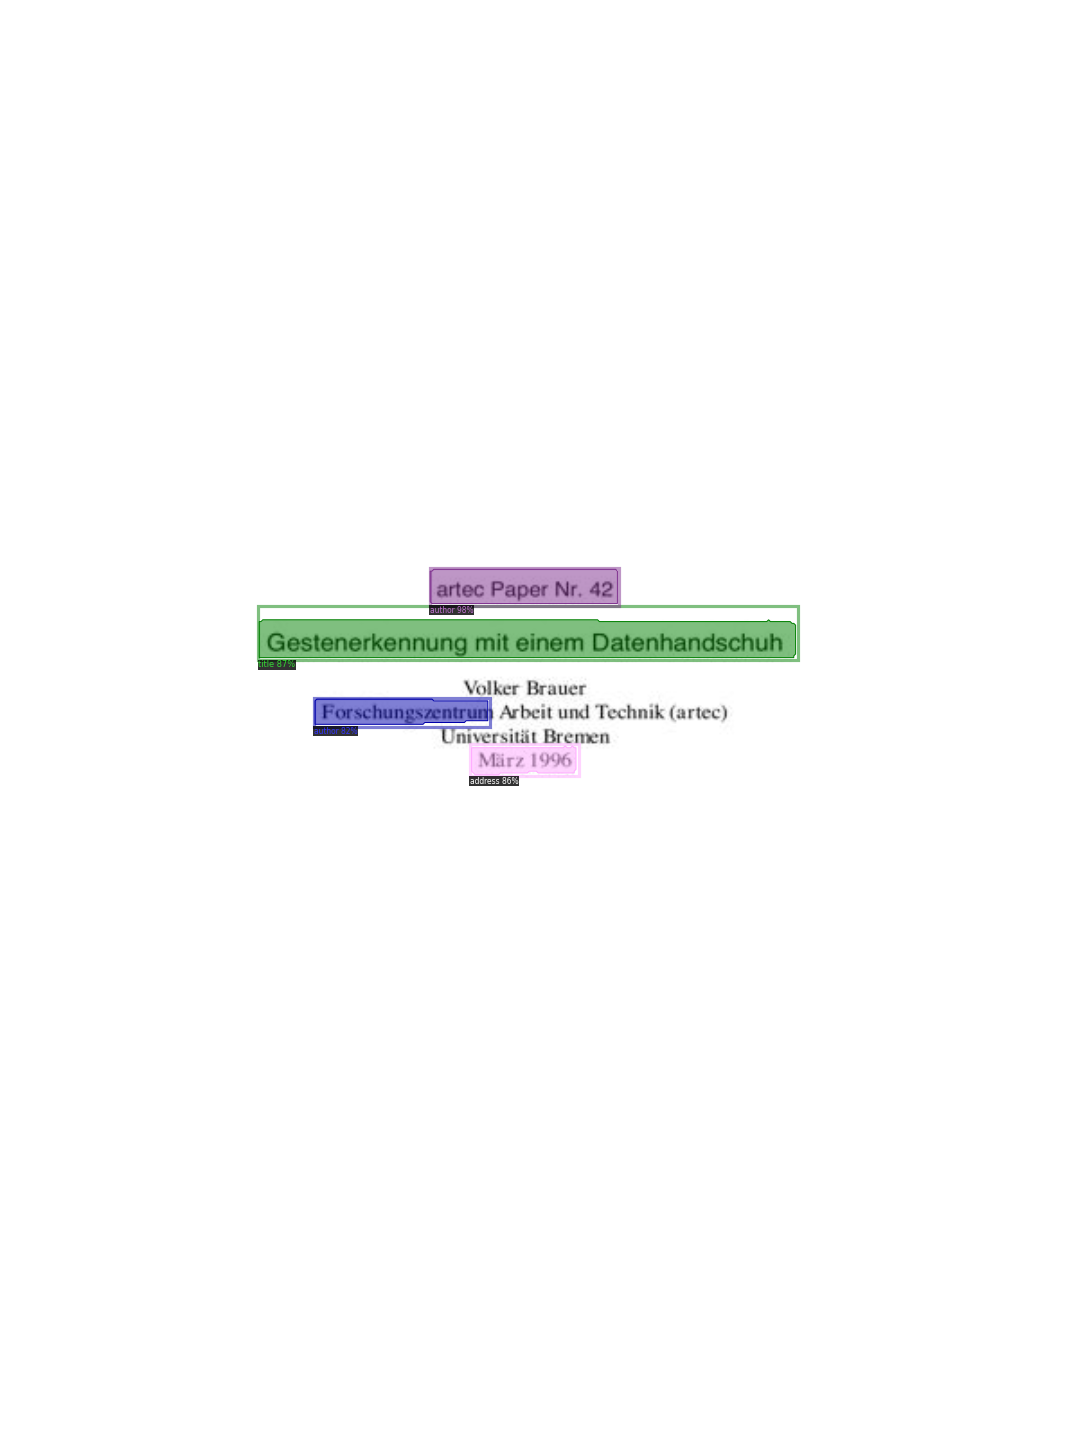

/content/Metadata-extraction-from-German-scientific-papers/new_annotations/test/11448.jpeg


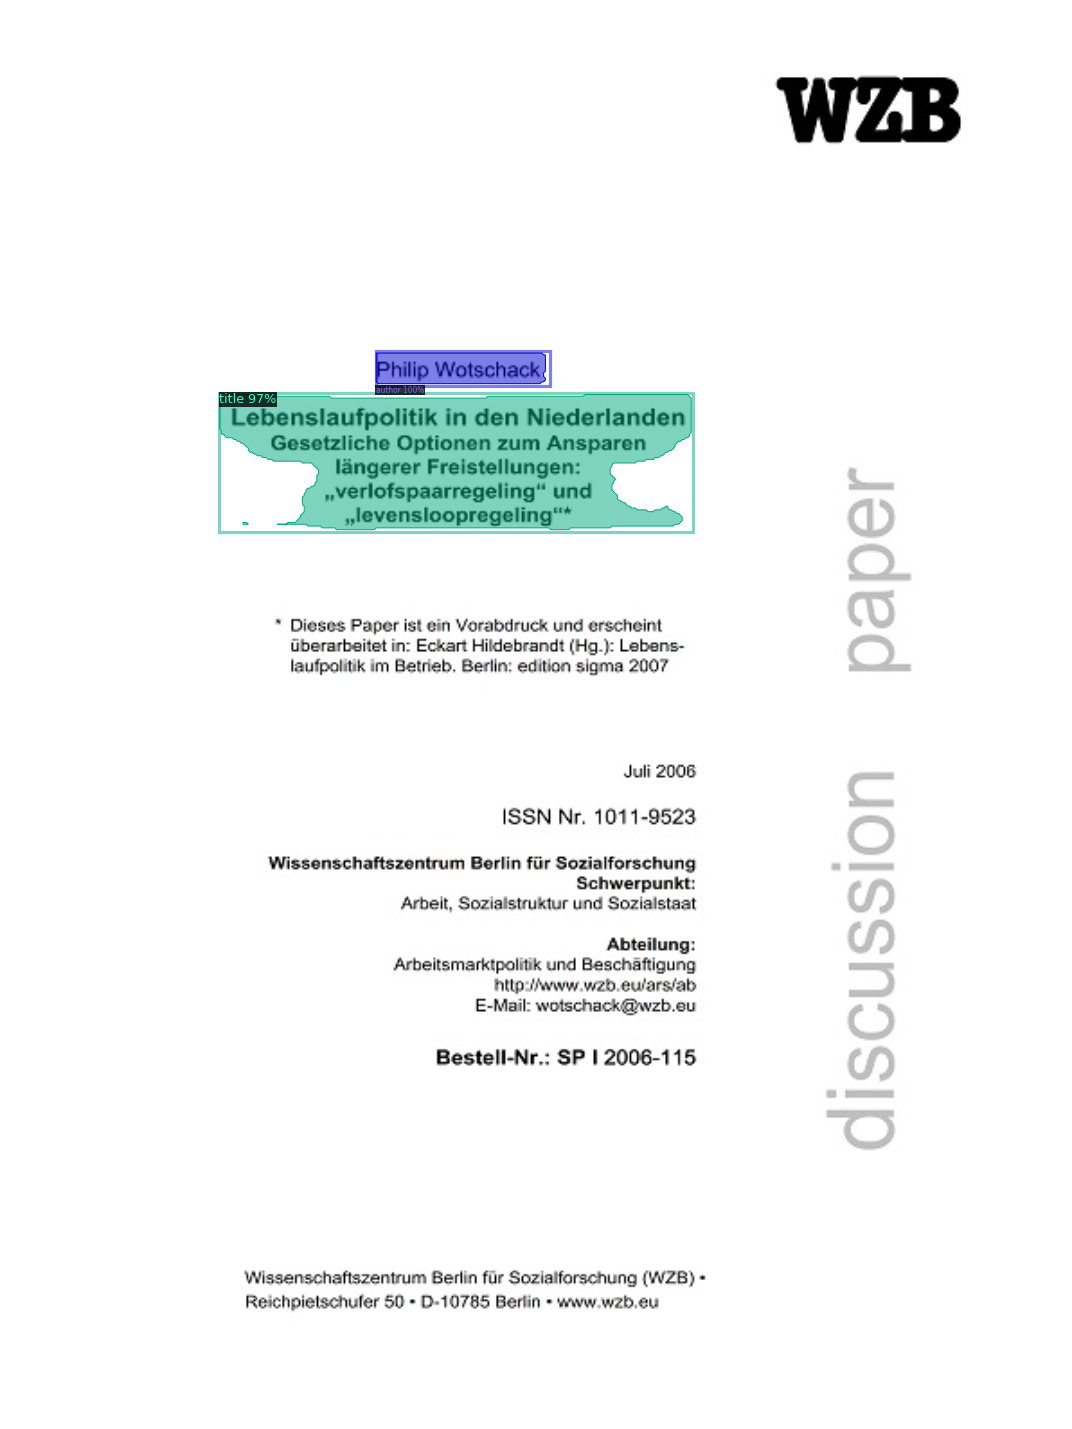

/content/Metadata-extraction-from-German-scientific-papers/new_annotations/test/10454.jpeg


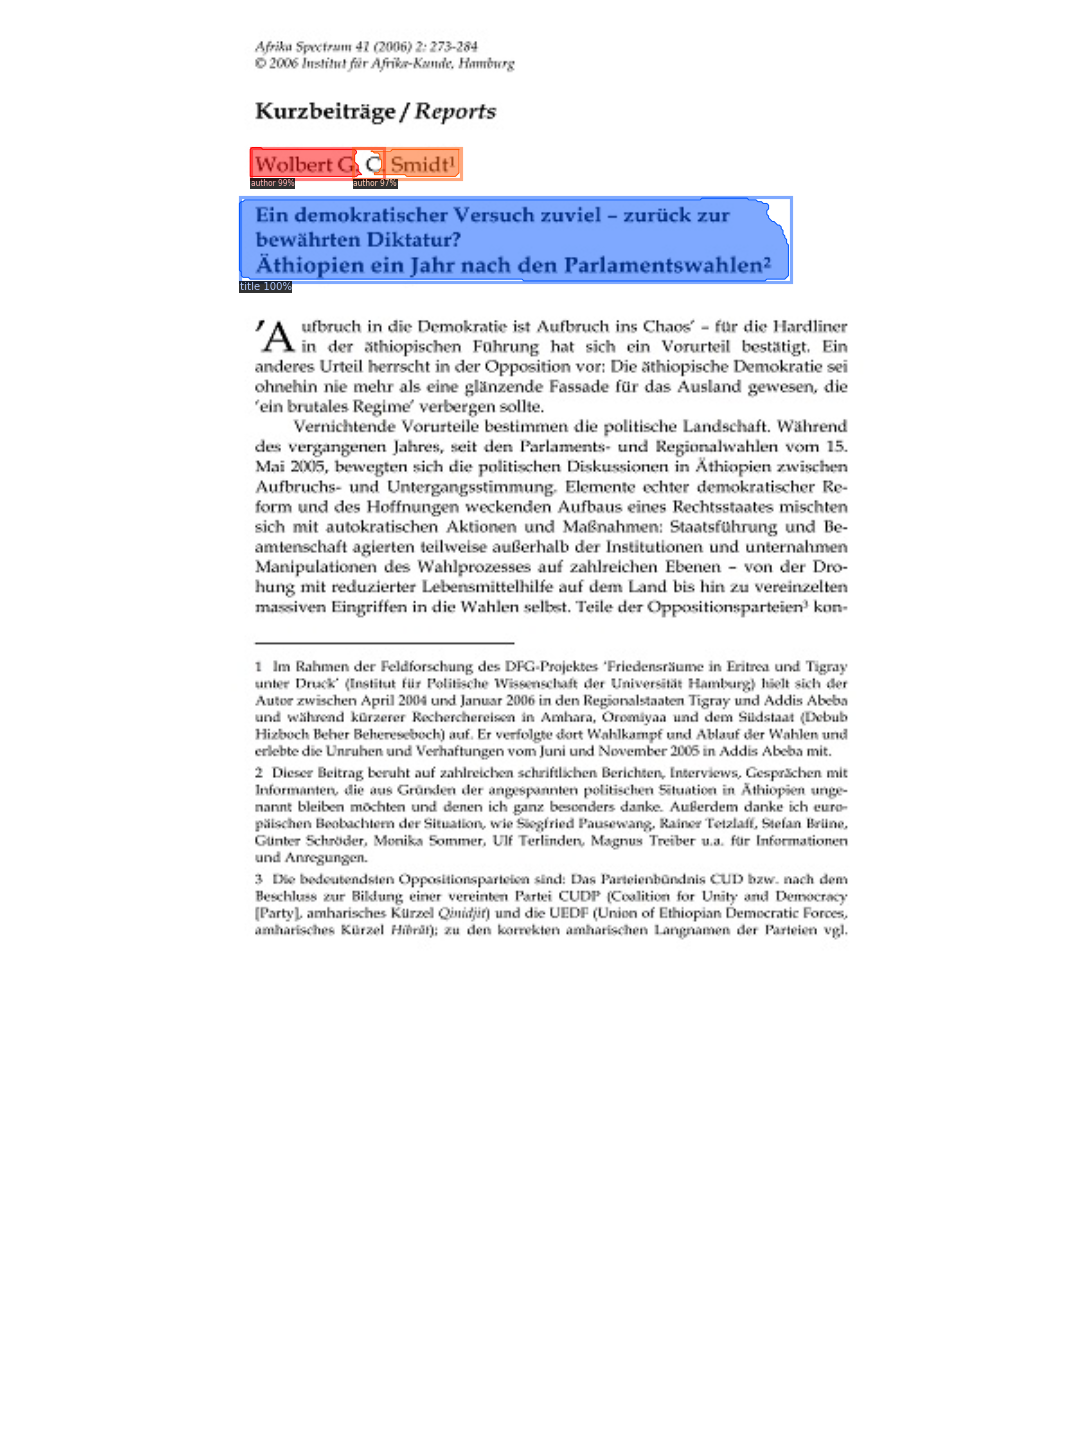

/content/Metadata-extraction-from-German-scientific-papers/new_annotations/test/17492.jpeg


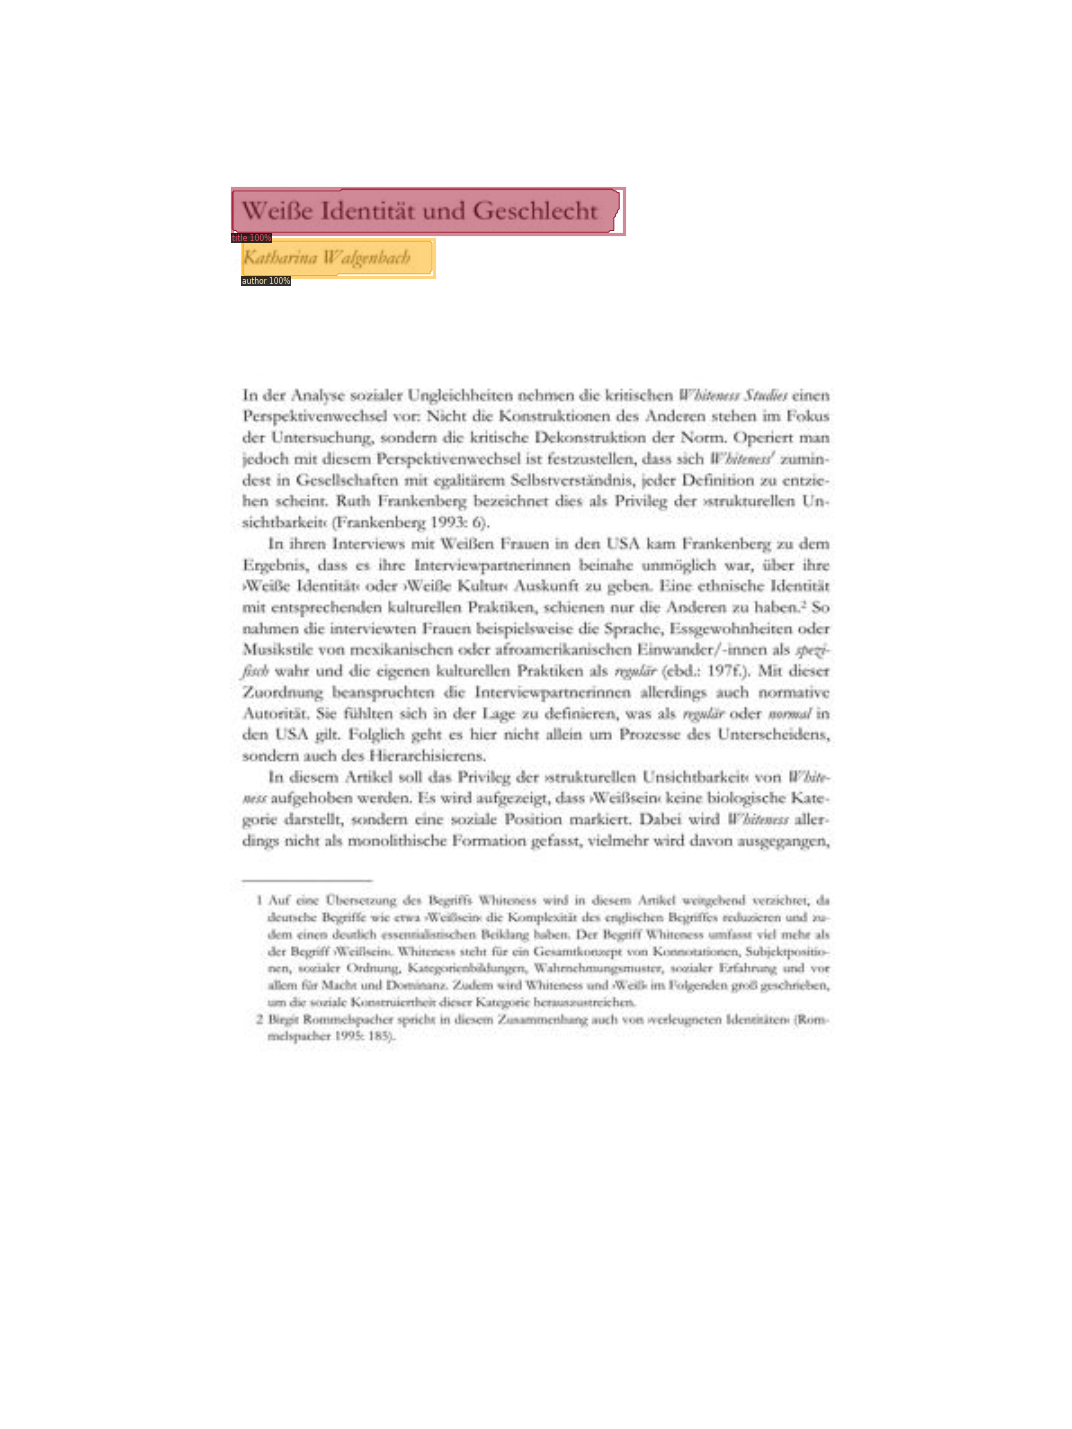

/content/Metadata-extraction-from-German-scientific-papers/new_annotations/test/31474.jpeg


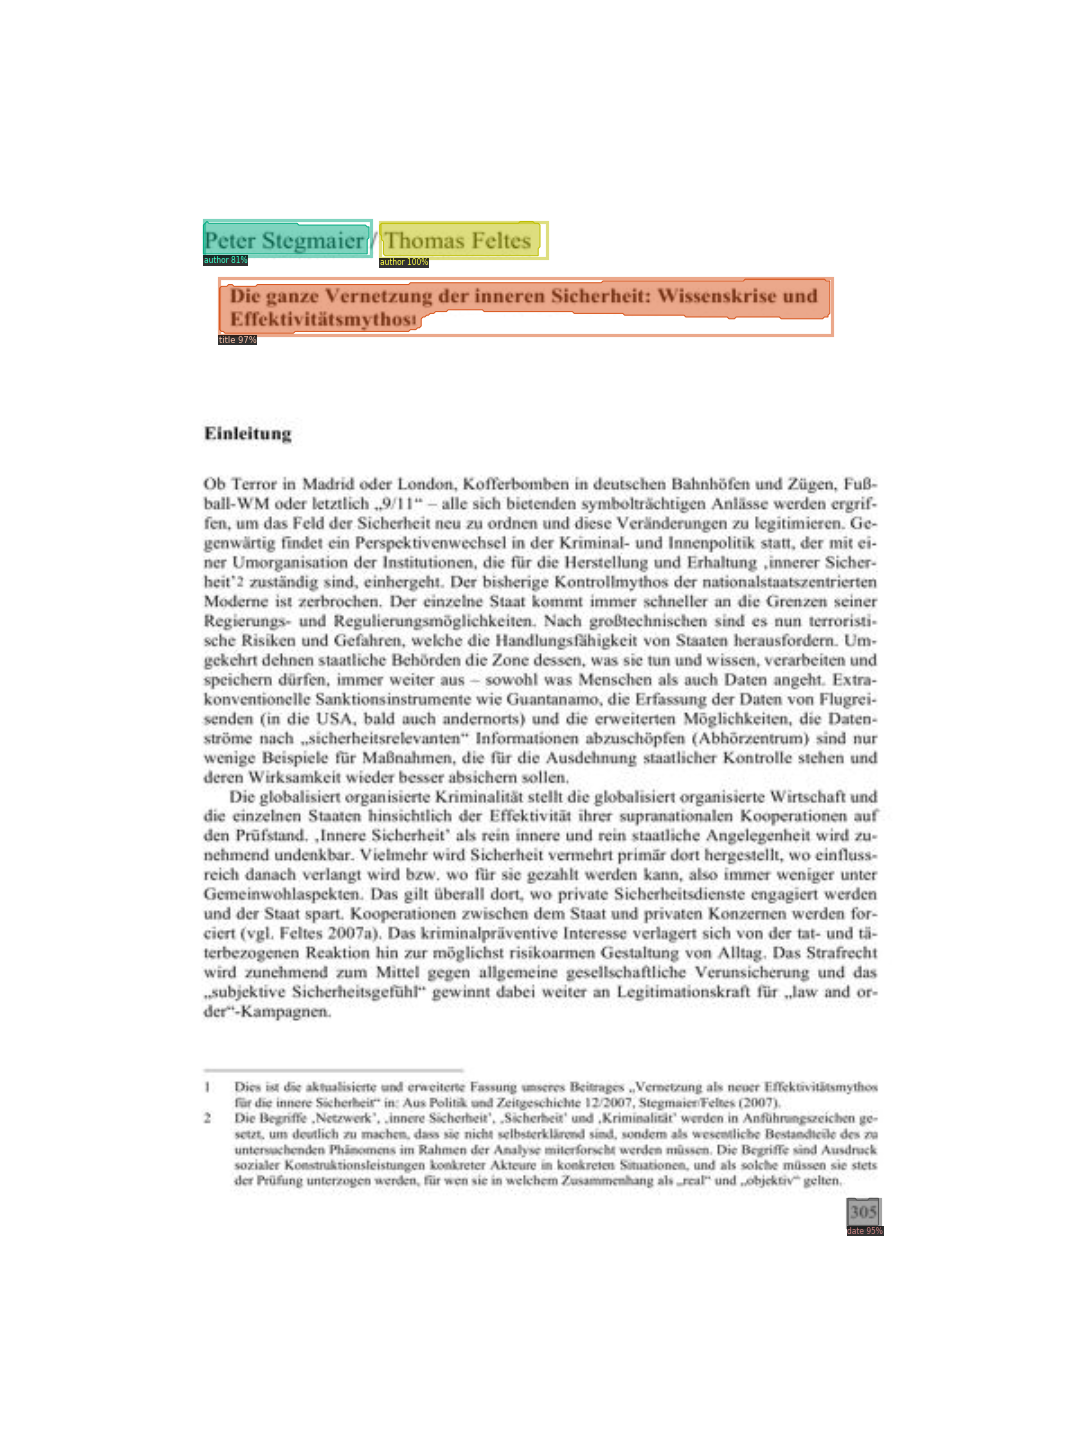

/content/Metadata-extraction-from-German-scientific-papers/new_annotations/test/11164.jpeg


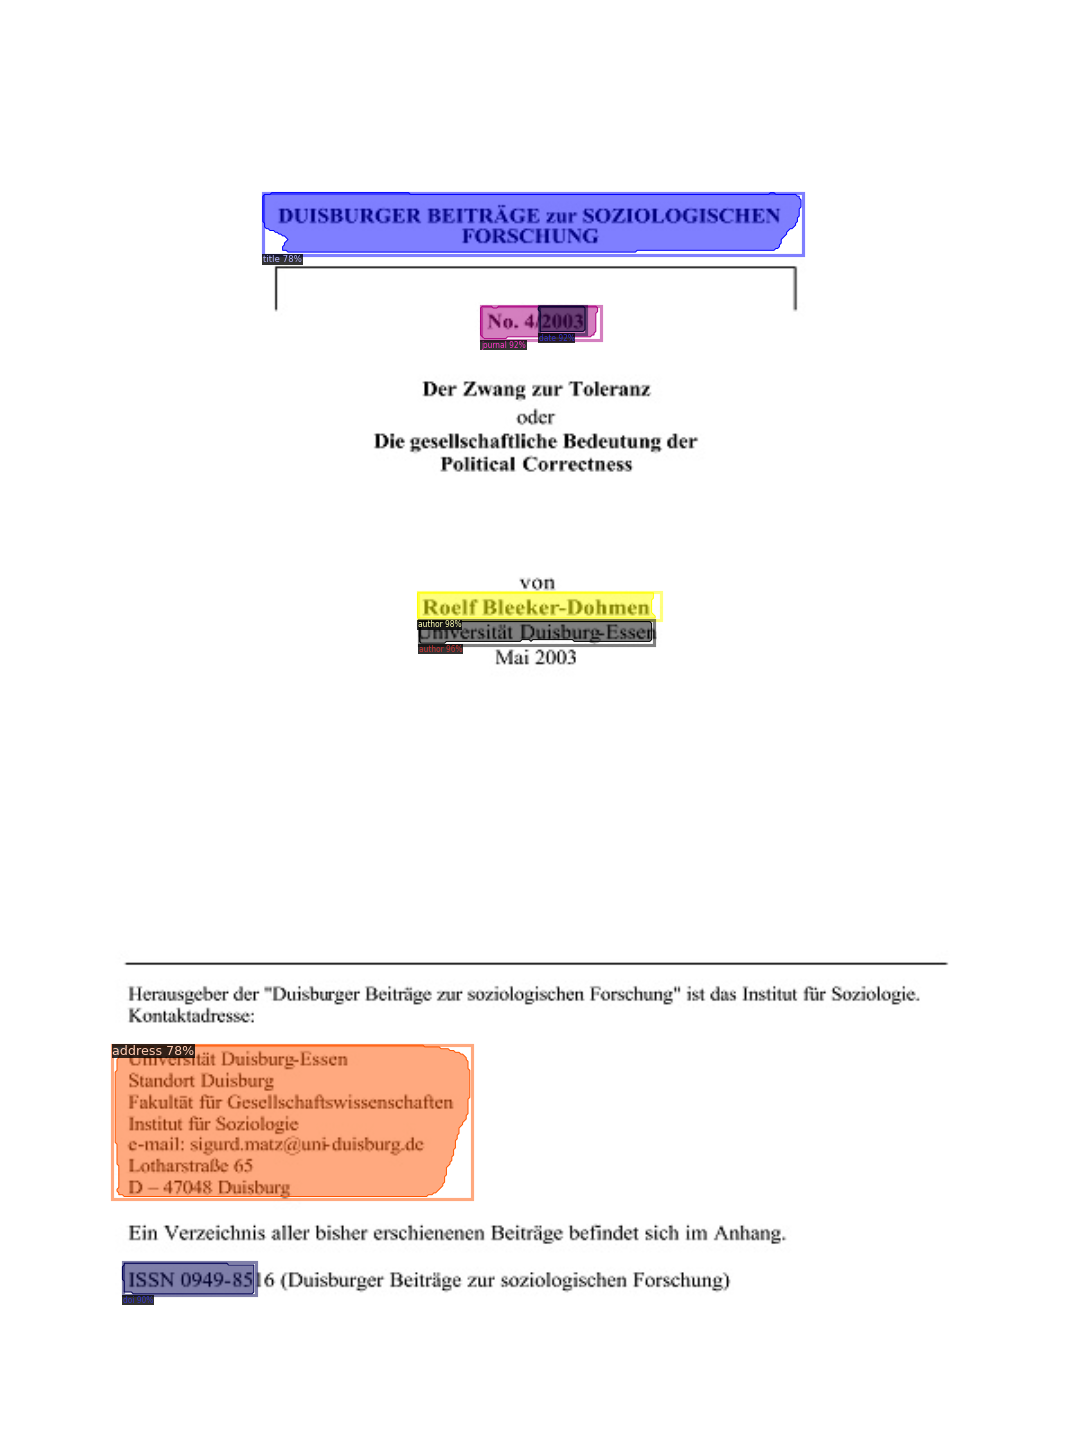

/content/Metadata-extraction-from-German-scientific-papers/new_annotations/test/19396.jpeg


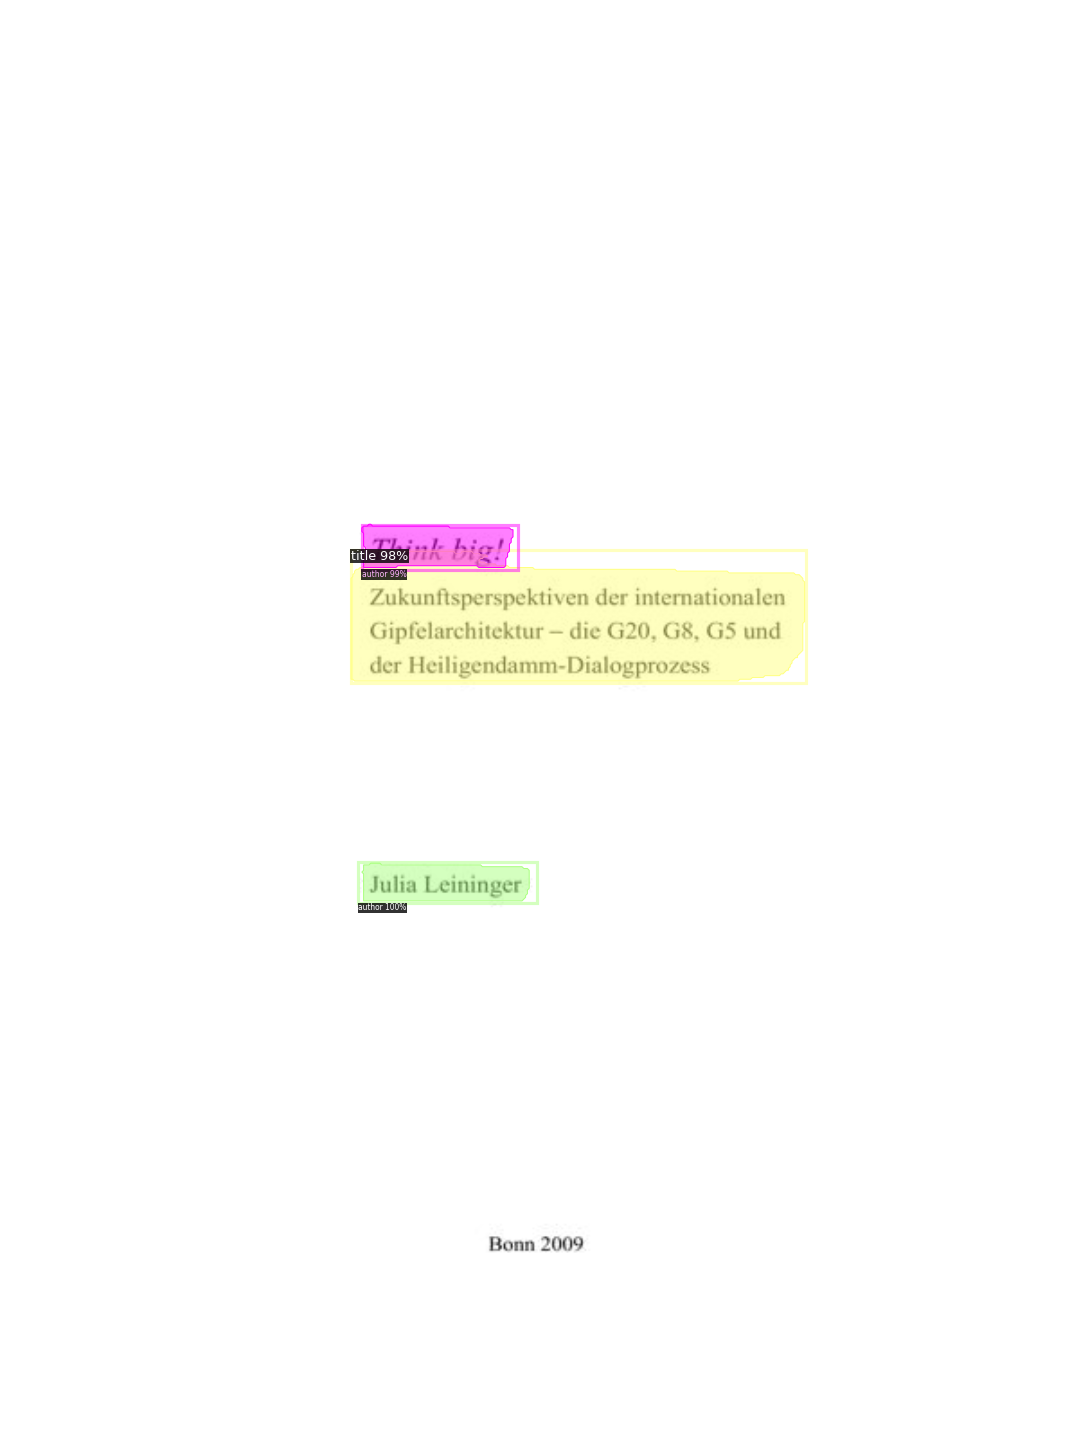

/content/Metadata-extraction-from-German-scientific-papers/new_annotations/test/12797.jpeg


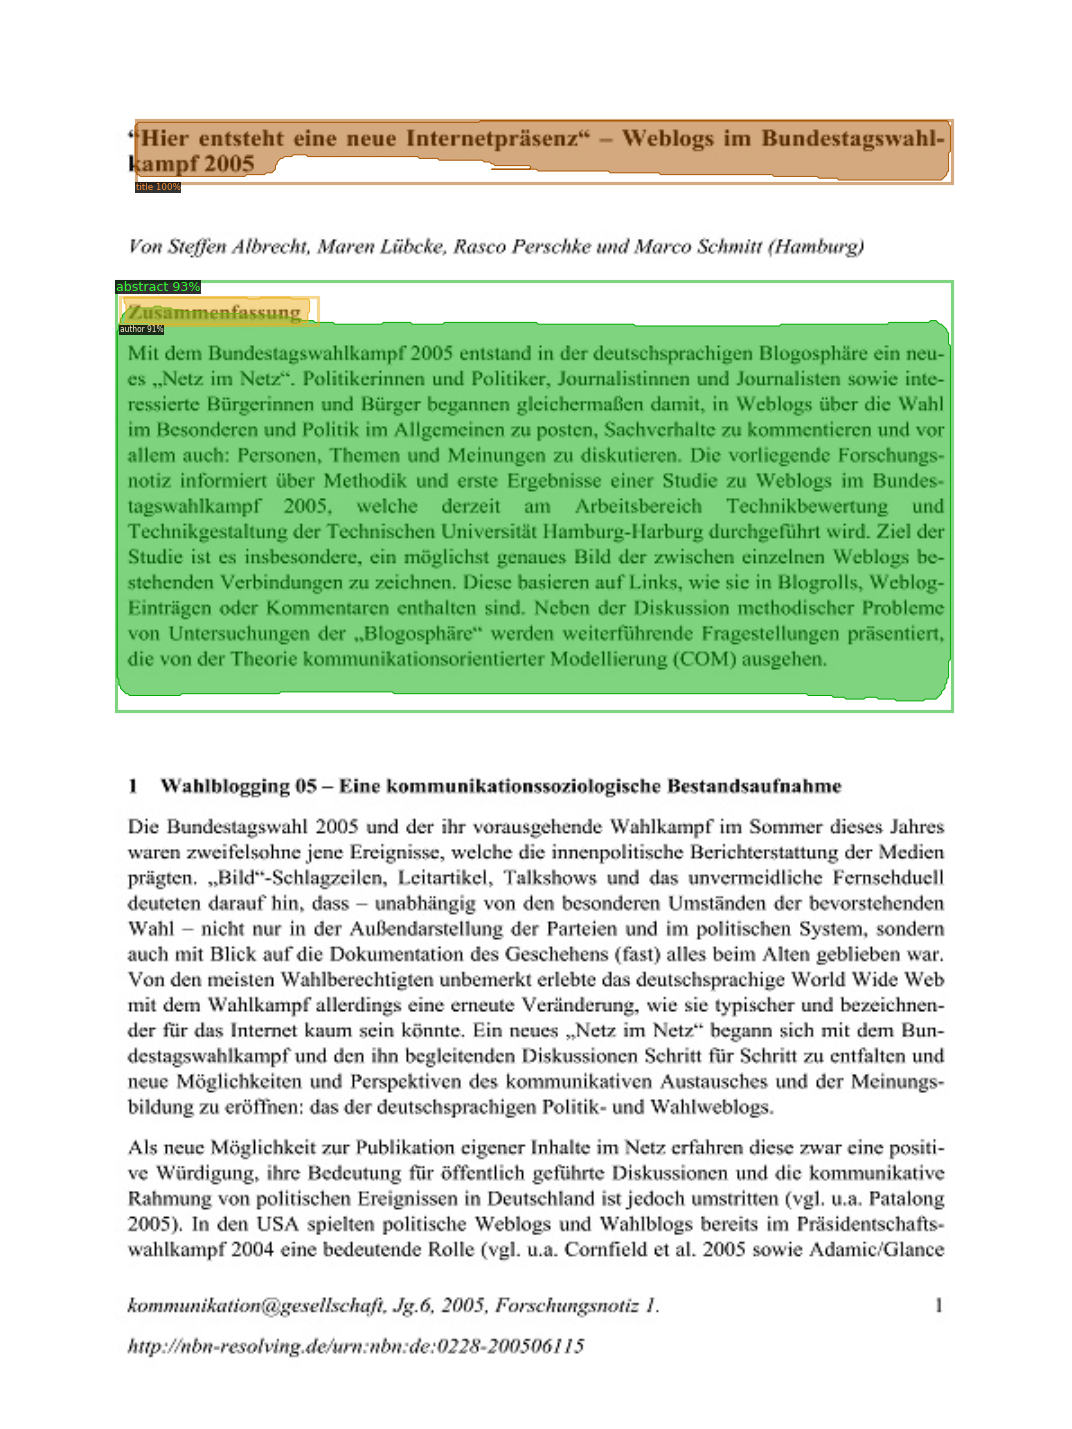

In [ ]:
from detectron2.utils.visualizer import ColorMode
import glob
for imageName in glob.glob('/content/Metadata-extraction-from-German-scientific-papers/new_annotations/test/*jpeg'):
    print(imageName)
    im = cv2.imread(imageName)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],metadata=test_metadata,scale=1.8)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])